# IBM Machine Learning
## Course 6: Time Series and Survival Analysis
## Topic: WDIData

### 1. Introduction
The primary World Bank collection of development indicators, compiled from officially-recognized international sources. It presents the most current and accurate global development data available, and includes national, regional and global estimates.
We will use the dataset to predict the growth of GDP per capita in Africa.

### 2. Explorative data analysis

#### 2.1 load Data

In [91]:
# Setupi
import warnings
warnings.filterwarnings('ignore')
import os
#os.chdir('data')

import pandas as pd
from pandas import DataFrame
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.preprocessing import scale

import statsmodels.formula.api as sm
from statsmodels.compat import lzip
import numpy as np
import statsmodels.api as sm

In [92]:
data=pd.read_csv('WDIData.csv')

In [93]:
## the columns names
data.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', 'Unnamed: 63'],
      dtype='object')

In [94]:
## extract the countries in south africa
data_sf=data[(data['Country Name'].str.contains('African|Benin|Burkina|Burundi|Cabo Verde|Cameroon|CAR|Chad|Comoros|Congo|Ivoire|Guinea|Eritrea|Eswatini|Ethiopia|Gambia|Ghana|Guinea|Guinea-Bissau|Kenya|Lesotho|Liberia|Madagascar|Malawi|Mali|Mauritania|Mauritius|Mozambique|Niger|Nigeria|Rwanda|Sao Tome|Senegal|Sierra Leone|South Sudan|Sudan|Tanzania|Togo|Uganda|Zambia|Zimbabwe')==True)]

In [95]:
data_sf.shape

(67158, 64)

In [96]:
## process the indicator
data_sf['Indicator Name']=data_sf['Indicator Name'].str.replace('(',':').str.replace(')',':')

In [97]:
data_sf=data_sf[data_sf['Indicator Name'].str.contains("GDP per capita, PPP :current international")==True]

In [98]:
data_sf.index=data_sf['Country Name']

In [99]:
data_sf=data_sf[data_sf.index.str.contains('Sao Tome and Principe|South Sudan|Papua New Guinea|Equatorial Guinea|Mauritius')==False]

In [100]:
data_sf=data_sf.fillna(method='bfill',axis=1)
data_sf=data_sf.fillna(method='ffill',axis=1)

In [101]:
data_sf=data_sf.iloc[:,34:-2]
ts=data_sf.mean()
ts=pd.DataFrame(ts)
ts.columns=['GDP per capita']

In [102]:
type(ts)

pandas.core.frame.DataFrame

#### 2.2 Time Series plot

Text(0, 0.5, 'GDP per capita')

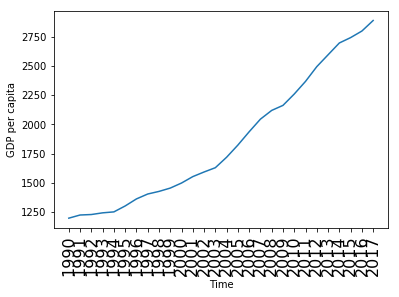

In [103]:
plt.plot(ts.index, ts['GDP per capita'])
plt.xlabel("Time")
plt.xticks(rotation=90)
plt.ylabel("GDP per capita")

From the time series figure above, the visual inspection of the time plot clearly indicates that Sub-Saharan GDP PPP per capita follows a positive additive growth pattern. The mean and the variance are clearly not constant. Therefore, we regard it as a non-stationary time series. (further below we will discuss the importance of making the time series stationary for model building)

#### 2.3 Time Series plot after log transformation

Text(0, 0.5, 'GDP per capita after log transformation')

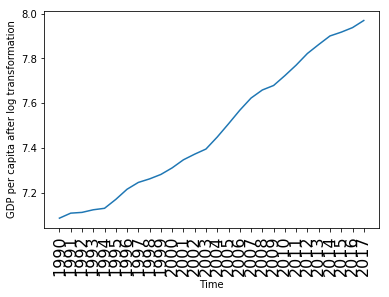

In [104]:
plt.plot(ts.index, np.log(ts['GDP per capita']))
plt.xlabel("Time")
plt.xticks(rotation=90)
plt.ylabel("GDP per capita after log transformation")

The "smoothing effect" of the log transformation is valuable both for making patterns of the data easy interpretable. The see that the log transformed time seriues follows the same growth dynamic as the original time series.

#### 2.4 Time Series growth dynamic 
We will examine the percentage change year by year

In [105]:
ts['change']=ts['GDP per capita'].pct_change().fillna(0)

In [106]:
ts['mean'] =ts['change'].mean()

In [107]:
ts

,GDP per capita,change,mean
1990,1197.366395,0.000000,0.032117
1991,1224.418997,0.022593,0.032117
1992,1228.560880,0.003383,0.032117
1993,1242.968652,0.011727,0.032117
1994,1251.163635,0.006593,0.032117
1995,1301.800159,0.040472,0.032117
1996,1362.174107,0.046377,0.032117
1997,1404.188766,0.030844,0.032117
1998,1426.551421,0.015926,0.032117
1999,1455.040204,0.019970,0.032117


Text(0, 0.5, 'GDP per capita percentage change')

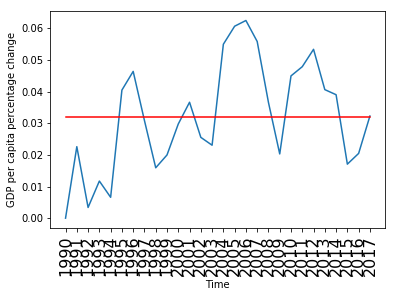

In [108]:
plt.plot(ts.index, ts['change'])
plt.plot(ts.index, ts['mean'], 'r', label="mean")
plt.xlabel("Time")
plt.xticks(rotation=90)
plt.ylabel("GDP per capita percentage change")

Analyzing the growth dynamic of the time series; We can identify some cyclic patterns. Thus, from 1990 to 1994 the growth is the lowest of the series. From 1994 to 1996 we see growth accelearating, with a slowdown in 1998. From 1998 to 2007, growth reaccelerates progressively (expect for the period 2001-2003); reaching a peak in 2006 (6.16%) (pre-depression period). The post-depression dynamics are marked by a recovery of the growth rates (rates higher than series 3% average) with a sharp drop in 2015 (growth of 1.5%). As of this year, the recent period initiates a bullish tends towards the 3% average of the series.

### 3. Model building

#### 3.1 Dickey-Fuller Test

In [109]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(ts['GDP per capita'])

print("ADF: ", adf)
print("p-value: ", pvalue)
print("Critical Values: ", critical_values)

ADF:  1.1308280964281299
p-value:  0.9954713272901851
Critical Values:  {'1%': -3.7112123008648155, '5%': -2.981246804733728, '10%': -2.6300945562130176}


it is evident that there is a trend in the data and that the data is not trend stationary.

The result of the Dickey-Fuller Test also confirms it.

#### 3.2 Time series decomposition

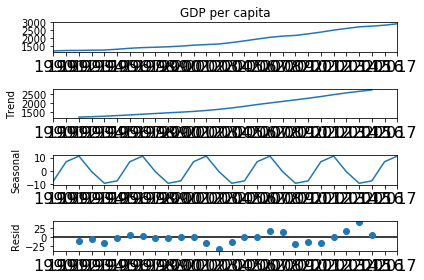

In [110]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(x=ts['GDP per capita'], model='additive', freq=5)

fig = decomposition.plot()
plt.show()

Our time series separated into its trend, seasonal, and residual components.

#### 3.3 Stationarize the time series
We assume that we can remove the trend/seasonality from our data using the first order differencing. (we take the first differences between values in the series, the order tells us how far apart these values are) Yt-Yt-1

In [111]:
y_diff = (ts['GDP per capita']).diff().dropna()
y_diff = pd.Series(y_diff )

Text(0, 0.5, 'GDP per capita after first order differencing')

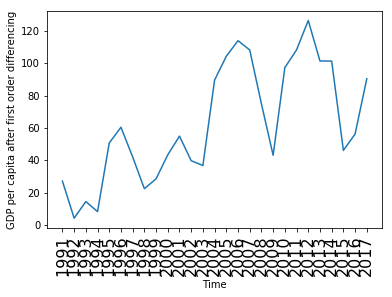

In [112]:
plt.plot(y_diff.index, y_diff.values)
plt.xlabel("Time")
plt.xticks(rotation=90)
plt.ylabel("GDP per capita after first order differencing")

In [113]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(y_diff)

print("ADF: ", adf)
print("p-value: ", pvalue)
print("Critical Values: ", critical_values)

ADF:  -1.9634815818189286
p-value:  0.30281102583766106
Critical Values:  {'1%': -3.7112123008648155, '5%': -2.981246804733728, '10%': -2.6300945562130176}


We see that our p value got a lot closer to 0.05, however, we still don't have a stationary series.

The application of the first difference seems to have extracted quite well the trend as well and made the time series standard deviation stationary. However, the test statistic is still larger than the critical value for a significance level of 5%.

Second-Order Differencing

As our differenced data is still not stationary another differencing step has to be included. This step indicates a higher order integration of the underlying process. We interpret the second level of differenced data as the “change of changes”.

In [114]:
y_diff2 = (ts['GDP per capita']).diff().diff().dropna()
y_diff2 = pd.Series(y_diff2 )

Text(0, 0.5, 'GDP per capita after second order differencing')

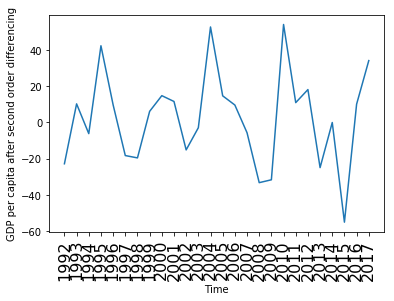

In [115]:
plt.plot(y_diff2.index, y_diff2.values)
plt.xlabel("Time")
plt.xticks(rotation=90)
plt.ylabel("GDP per capita after second order differencing")

In [116]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(y_diff2)

print("ADF: ", adf)
print("p-value: ", pvalue)
print("Critical Values: ", critical_values)

ADF:  -4.1167136633141075
p-value:  0.000908715565435346
Critical Values:  {'1%': -3.7883858816542486, '5%': -3.013097747543462, '10%': -2.6463967573696143}


We see that the DF test statistic is already smaller that 1% percent significance.

#### 3.4 ARIMA(p, d, q) model

ACF plot

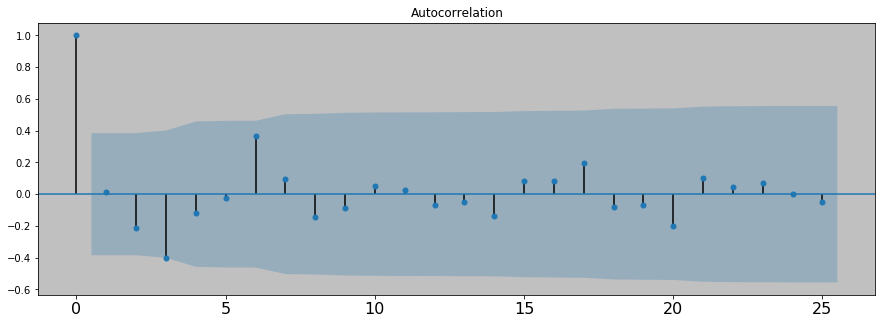

In [117]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_facecolor('silver')
plt.rc('xtick', labelsize=16)
sm.graphics.tsa.plot_acf(y_diff2,ax=ax,lags=25)
plt.show()

PACF plot

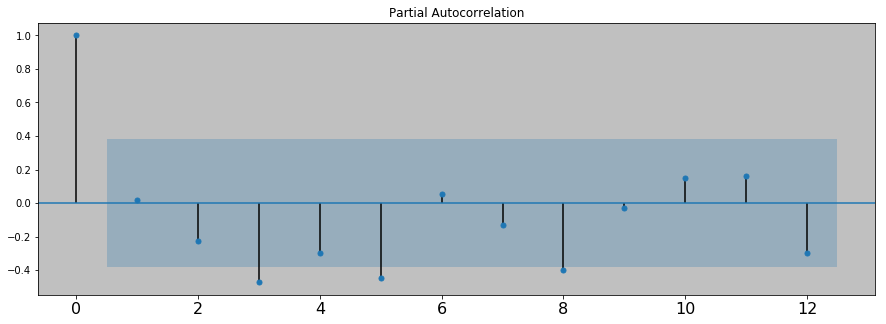

In [118]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_facecolor('silver')
sm.graphics.tsa.plot_pacf(y_diff2,ax=ax, lags=12)
plt.show()

ORDER p

    The PACF shows conveys the pure correlation between a lag and the series. Order 3 is the first above the significance line. We choose this value in order to keep the model as simple as possible.

ORDER d

    We already detected order of integration 2 in order to make the series stationary.

ORDER q

    Using ACF plot we can gauge the number of MA terms. An MA term is technically, the error of the lagged forecast. Order 3 is the first above the significance line; we choose this value in order to keep the model as simple as possible.

In [119]:
mod = sm.tsa.statespace.SARIMAX(ts['GDP per capita'].values,order=(3,2,3),enforce_stationarity=True,enforce_invertibility=True, maxiter=1000, method='css')
results1 = mod.fit()
print(results1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:               SARIMAX(3, 2, 3)   Log Likelihood                -116.950
Date:                Wed, 23 Dec 2020   AIC                            247.900
Time:                        01:23:31   BIC                            256.706
Sample:                             0   HQIC                           250.436
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2980      0.757      0.394      0.694      -1.185       1.781
ar.L2          0.1719      0.749      0.229      0.819      -1.297       1.640
ar.L3         -0.7630      0.473     -1.614      0.1

 Diagnostic plots for standardized residuals

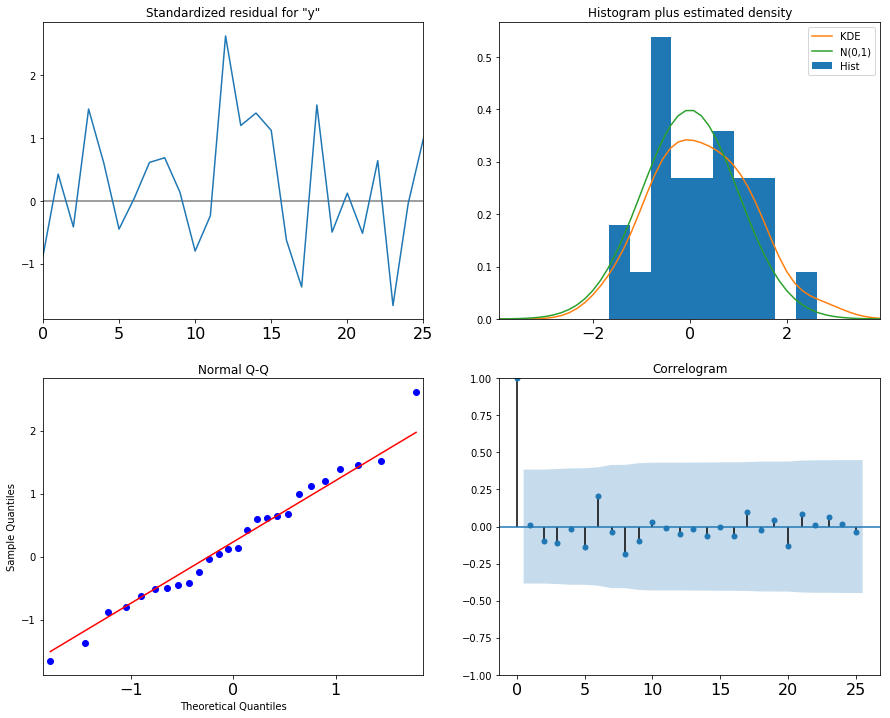

In [120]:
results1.plot_diagnostics(figsize=(15, 12),lags=25)
plt.show()

#### 3.5  In-sample prediction and out-of-sample forecasting of SSA GDP per capita to 2030

In [121]:
forecast=results1.predict(start=0,end=40)
forecast=pd.DataFrame(forecast, columns = ['projection'])
forecast.index=['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017','2018','2019','2020','2021','2022','2023','2024','2025','2026','2027','2028','2029','2030']

Text(0, 0.5, 'GDP per capita')

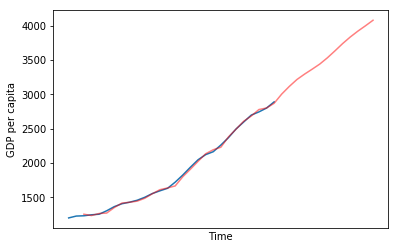

In [122]:
plt.plot(ts.index, ts['GDP per capita'])
plt.xlabel("Time")
plt.xticks([])

plt.plot(forecast.iloc[2:].index, forecast.iloc[2:].projection, 'r', label="projection", alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("GDP per capita")

In [123]:
prediction_summary=results1.get_prediction(start=0, end=40).summary_frame()
prediction_summary.index=['1990-01-01', '1991-01-01','1992-01-01','1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01',
               '2024-01-01', '2025-01-01', '2026-01-01', '2027-01-01',
               '2028-01-01', '2029-01-01', '2030-01-01']

In [124]:
prediction_summary.iloc[2:].mean_ci_lower.values

array([1200.62721681, 1181.22565248, 1211.67851755, 1223.38645796,
       1305.53267702, 1371.77741792, 1383.6150235 , 1399.92741286,
       1442.2264458 , 1508.9305469 , 1568.45119732, 1593.34848037,
       1622.7980969 , 1757.1302951 , 1866.93393304, 1980.91747015,
       2092.3330191 , 2150.98967557, 2187.58201223, 2338.17675338,
       2451.58663018, 2566.32428264, 2643.3953748 , 2737.72905306,
       2759.91385105, 2828.59434066, 2963.50647443, 3033.4117251 ,
       3092.3048825 , 3135.44404492, 3173.23344925, 3210.96303624,
       3255.89370761, 3301.8298849 , 3344.46628208, 3376.22103027,
       3398.81712572, 3415.09673727, 3432.96420588])

Text(0, 0.5, 'GDP per capita')

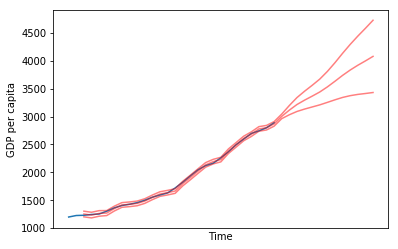

In [125]:
plt.plot(ts.index, ts['GDP per capita'])
plt.xlabel("Time")
plt.xticks([])

plt.plot(forecast.iloc[2:].index, forecast.iloc[2:].projection, 'r', label="projection", alpha=0.5)
plt.plot(forecast.iloc[2:].index, prediction_summary.iloc[2:].mean_ci_lower.values, 
         color='r', label="ARIMA model 95% Lower CI", alpha=0.5)
plt.plot(forecast.iloc[2:].index, prediction_summary.iloc[2:].mean_ci_upper.values, 
         color='r', label="ARIMA model 95% Upper CI", alpha=0.5)
plt.ylabel("GDP per capita")

### 4. Conclusion

Taking into account the underlying patterns of both time series, without a structural change in the regional GDPpc time series, SSA will continue being the underdog of the global economy for the next decade and the divergence with the world average is only likely to increase. Our model indicates that if the current underlying trends are to continue, the regional GDPpc as a percentatge of the world average will decrease to around 15% at the end of the 30s decade from the current value of around 17%. The current structural trend of the region’s GDPpc growth remains weak. A much more explosive growth pattern is highly needed to converge with the world average. Returning to pre-crisis levels of around 5% growth would bring the region in the convergence world average path.

Altough, its true that the region is experiencing a much explosive population growth than the rest of the world; it also departs from a much lower position, which allows to accumulate higher scaled levels of economic output.

Many economists suggest that SSA is too resourced-focus and manufacture-absent, which historical data tells it is the "standard model" followed by the majority of countries to have successfully transitioned from low-to middle or high income status. It's also true that western agricultural and commercial policies are still very damaging to SSA economic interests, but the region will only converge with the world average if decisive "game-changing" socio-economic and institutional reforms are implemented. Regarding the later, the Ethiopian example, one of the poorest countries in the world in 2000 and now one of the fastest-growing economies in the world, sheds some light, into the path to follow for the most vulnerable nations.